### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

# Project path
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data/')

images_data = pd.read_csv(cwd+"/images_data.csv")
images_data['label'] = images_data['label'].astype(str)

train_data = images_data.loc[images_data['classes']=='train']
test_data = images_data.loc[images_data['classes']=='test']

In [2]:
train_data.head()

,classes,label,full_path,width,height,ratio
12500,train,0,/home/workspace/capstone/MachineLearningProjec...,226,431,0.524362
12501,train,0,/home/workspace/capstone/MachineLearningProjec...,375,499,0.751503
12502,train,1,/home/workspace/capstone/MachineLearningProjec...,375,499,0.751503
12503,train,0,/home/workspace/capstone/MachineLearningProjec...,337,500,0.674000
12504,train,1,/home/workspace/capstone/MachineLearningProjec...,500,277,1.805054


In [3]:
!pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-wg7bwhx6
  Running setup.py bdist_wheel for Keras-Preprocessing ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-mit76jry/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [18]:
from keras_preprocessing.image import ImageDataGenerator

def get_images_generator(image_size):
    img_gen = ImageDataGenerator(rescale=1.0/255)
    train_img_generator = img_gen.flow_from_dataframe(
                                    dataframe=train_data,
                                    directory=data_dir+'train',
                                    x_col='full_path',
                                    y_col='label',
                                    target_size=image_size,
                                    class_mode='binary',
                                    batch_size=1
                                    )

    test_img_generator = img_gen.flow_from_dataframe(
                                    dataframe=test_data,
                                    directory=data_dir+'test',
                                    x_col='full_path',
                                    target_size=image_size,
                                    class_mode = None,
                                    batch_size=1)
    return (train_img_generator, test_img_generator)

Found 24997 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


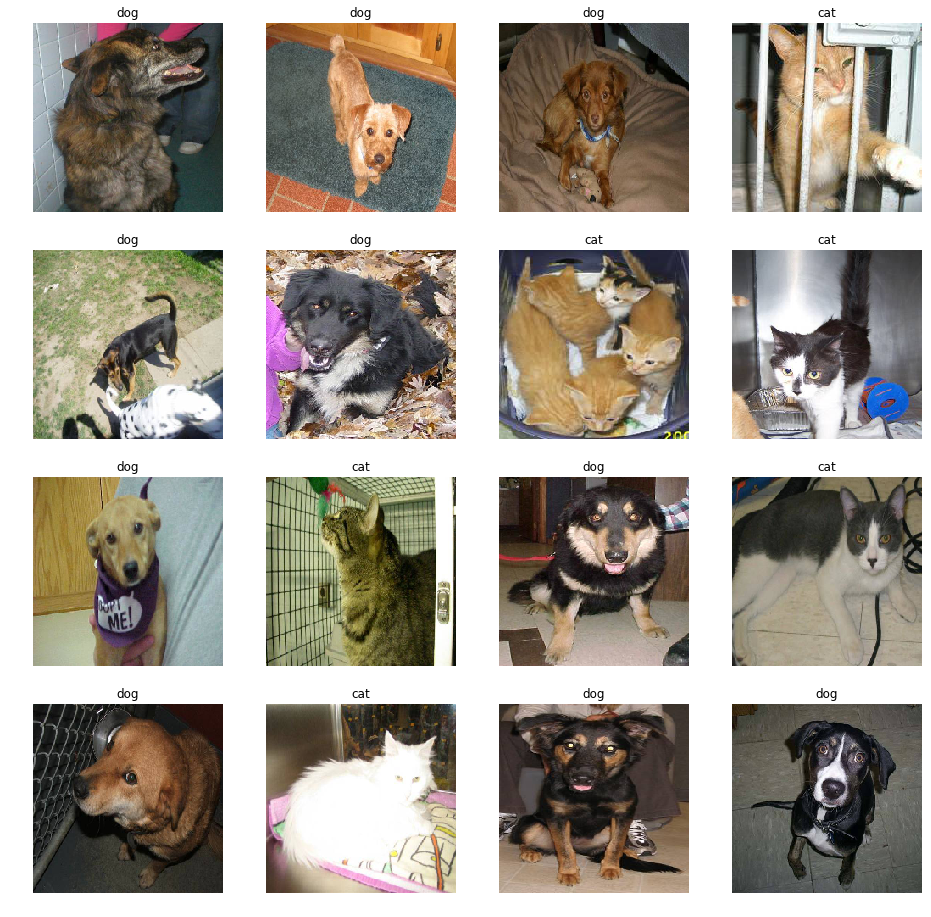

In [26]:
import matplotlib.pyplot as plt

image_size = (224, 224)

(train_img_generator, _) = get_images_generator(image_size)

plt.figure(figsize=(16, 16))
for i in list(range(16)):
    (img, label) = train_img_generator.next()
    plt.subplot(4, 4, i+1)
    if label == 1:
        plt.title('dog') 
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img[0,:,:,:], interpolation="nearest")

In [6]:
from keras.models import *
from keras.layers import *
from keras.applications import *

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    (train_img_generator, test_img_generator) = get_images_generator(image_size)
    
    train = model.predict_generator(train_img_generator, train_img_generator.samples)
    test = model.predict_generator(test_img_generator, test_img_generator.samples)
    
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_img_generator.classes)

Using TensorFlow backend.


In [7]:
write_gap(ResNet50, (224, 224))
#write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
#write_gap(Xception, (299, 299), xception.preprocess_input)

Found 24997 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.
83689472/83683744 [==============================] - 1s 0us/step
Found 24997 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [10]:
import h5py
from sklearn.utils import shuffle
np.random.seed(20)

def train_func(mode_name, optimizer_name="adam"):
    X_train = []
    X_test = []
    
    with h5py.File(mode_name, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

    X_train = np.concatenate(X_train, axis=1)
    X_test = np.concatenate(X_test, axis=1)

    X_train, y_train = shuffle(X_train, y_train)
    
    input_tensor = Input(X_train.shape[1:])
    x = Dropout(0.5)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)

    model.compile(optimizer=optimizer_name,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    train_history = model.fit(X_train, y_train, batch_size=16, nb_epoch=8, validation_split=0.2)
    
    return model, train_history
    

In [ ]:
model_list = []
train_history_list = []
opt_list = ["adadelta","adam","sgd"]
mode_name_list = ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]
for mode_name in mode_name_list:
    for opt in opt_list:
        model, train_history = train_func(mode_name, opt)
        model_list.append(model)
        train_history_list.append(train_history)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 19997 samples, validate on 5000 samples
Epoch 1/8
19997/19997 [==============================] - 6s 314us/step - loss: 0.7088 - acc: 0.4991 - val_loss: 0.6936 - val_acc: 0.4820
Epoch 2/8
19997/19997 [==============================] - 6s 287us/step - loss: 0.6967 - acc: 0.5079 - val_loss: 0.6934 - val_acc: 0.4924
Epoch 3/8
19997/19997 [==============================] - 6s 287us/step - loss: 0.6977 - acc: 0.4962 - val_loss: 0.6978 - val_acc: 0.4862
Epoch 4/8
19997/19997 [==============================] - 6s 285us/step - loss: 0.6967 - acc: 0.4993 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 5/8
19997/19997 [==============================] - 6s 284us/step - loss: 0.6965 - acc: 0.5011 - val_loss: 0.6928 - val_acc: 0.5150
Epoch 6/8
19997/19997 [==============================] - 6s 282us/step - loss: 0.6965 - acc: 0.5029 - val_loss: 0.6929 - val_acc: 0.5122
Epoch 7/8
19997/19997 [==============================] - 6s 285us/step - loss: 0.6952 - acc: 0.5095 - val_loss: 0.6929 - val_acc:

In [ ]:
def get_image(image_num):
    img = cv2.imread('image/test/{}.jpg'.format(image_num))
    img = cv2.resize(img, target_image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

In [ ]:
# create kaggle file
def generate_kaggle_file(pred_array,file_name):
    df = pd.read_csv("sample_submission.csv")
    df["label"] = pred_array
    print(file_name)
    df.to_csv('submission_{}.csv'.format(file_name), index=None)

In [ ]:
from tqdm import *

image_matrix = np.zeros((test_num,target_image_size[0], target_image_size[0], 3), dtype=np.float32)
test_num = 12500

for i in tqdm(range(test_num)):
    image_matrix[i] = get_image(i+1)

In [ ]:
opt_list = ["adadelta","adam","sgd"]
for opt in opt_list:
    weights_name = 'resnet_best_binary_crossentropy_{}.h5'.format(opt)
    model.load_weights(weights_name)
    pred = model.predict(image_matrix, verbose=1)
    pred = pred.clip(min=0.005, max=0.995)
    generate_kaggle_file(pred,opt)

In [ ]:
'''
for train_history in train_history_list:
    plt.plot(train_history.history['val_loss'])
    plt.xlabel('time')
    plt.ylabel('val_loss')
    plt.show()

    plt.plot(train_history.history['val_acc'])
    plt.xlabel('times')
    plt.ylabel('val_acc')
    plt.show()
'''

In [ ]:
'''
plt.figure(figsize=(12, 4))
for i in range(10):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))
    prediction = prediction[0]
    
    plt.subplot(2, 5, i+1)
    
    if prediction < 0.5:
        
        plt.title("cat {:.2f}%".format(100 - float(prediction)*100))
    else:
        plt.title("dog {:.2f}%".format(float(prediction)*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) 
'''
